In [1]:
import bz2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tld import get_tld

def get_domain(url):
    res = get_tld(url, as_object=True)
    return res.tld

from urllib.parse import urlparse
def get_url(url):
    return urlparse(url).netloc
import ast

In [2]:
word_list = ['jinping xi', 'xi jing ping', 'xi jinping', 'president xi',
             'china', 'chinese', 'beijing', 'peking', 'ccp', 'prc', 'sino-']

## Initial idea
Here we have the initial idea where we extracted quotes that contained words related to China. Our idea with this was that, if the title contained any word related to China, the quotes in the article may be abut China aswell

In [3]:
# Load the data which contained a China related word in the title
path_to_out = 'C:/Users/jozef/Desktop/quotebank/quotebank-2020-contains-related.json.bz2'
df = pd.read_json(path_to_out ,lines=True)

Here we look at the titles, to see if they make sense

In [4]:
for title in df['title'].head(5):
    print(title)
    print()

Coronavirus LIVE updates : Death toll in China crosses 2,000 , UN says very dangerous situation

Serbia offers support to China in ` battle ' with new virus

Home News Rajasthan News Congress leader Kodikunnil Suresh condemns Nagaur incident , says Rajasthan govt should compensate victims New Delhi , Feb 22 : Congress chief whip in Lok Sabha Kodikunnil Suresh on Friday condemned the  rutal violence and assault against two Dalit youths in Rajasthan 's Nagaur district and added that the state government must provide adequate compensation to the victims . In his letter to Rajasthan Chief Minister Ashok Gehlot , Suresh expressed `` angst and disbelief at the level of violence that was unleashed upon the two Dalit youths as they were subjected to barbaric torture even when they were pleading with the perpetrators , '' read a statement . Suresh stated in his letter that the Rajasthan government must take all measures and take swift action against the perpetrators of this `` heinous crime , 

Above we see that the 3rd title is much too long, and is probably due to a data collection issue on the side of quotebank. Sice we would like to extract meaningful information from the title later on, we decided to remove articles with long titles from the dataset.

C:\Users\jozef\anaconda3\envs\ada\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='title', ylabel='Density'>

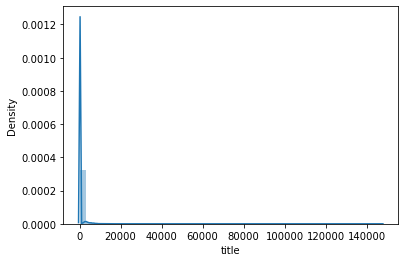

In [5]:
sns.distplot(df['title'].apply(len))

Here we see that the length of the titles are highly concentrated around 0, but also contains outliers which run up to 140k characters.

In [6]:
df['title'].apply(len).quantile(0.90)

115.0

Here we see that 90% of the samples have a length of below 115, we therefore choose to remove articles that have a length of above 200. We chose 200 since this statistic is only computed on the 2020 dataset, and we thus take 200 as an upper bound since the other years may be different

In [7]:
df = df[df['title'].apply(len) <= 200]

## Country 

Since we want to have the view from western press, the next step we need is to filter the data that from other countries like Egypt. First, we thought about using the name and the top level domain of the url to tell where every quote belong to. 

In [8]:
df['url'].apply(lambda x: get_url(x)).value_counts()

www.breitbart.com             987
msn.com                       612
brazilbusiness.einnews.com    544
www.theepochtimes.com         514
www.channelnewsasia.com       421
                             ... 
www.ukiahdailyjournal.com       1
cdispatch.com                   1
www.thecheckeredflag.co.uk      1
www.socialistparty.org.uk       1
winghamchronicle.com.au         1
Name: url, Length: 3510, dtype: int64

As shown above, the url can not give a very precise result on which country quote belongs. For example, 'channelnewsasia.com' is obviously an asian media outlet but with a top level domain `.com`. 

Therefore, we think it is a better way to combine the Wikidata to get the detailed information of the speakers, and to filter by the data with speakers' nationality. We also need this data for later processes for example get the difference in attitude by politcal affiliation or by gender.

## Quotations

Next we would like to look at the actual quotations in the data-set, the code below creates a new dataframe containing all the quotes of all the articles.

In [9]:
quote_df = pd.DataFrame(list(df['quotations'].apply(pd.Series).stack()))

In [10]:
quote_df.head(5)

,quotationOffset,quoteID,numOccurrences,quotation,leftContext,rightContext,globalTopSpeaker,globalProbas,localTopSpeaker,localProbas
0,140,2020-02-18-006228,44,appears to show a decline in new cases,". However, the death toll crossed 2,000 in mai...",but any apparent trend [QUOTE],Tedros Adhanom Ghebreyesus,"[[Tedros Adhanom Ghebreyesus, 0.9334], [None, ...",Antonio Guterres,"[[Antonio Guterres, 0.6763], [None, 0.3237]]"
1,154,2020-02-17-045269,171,must be interpreted very cautiously.,. UN Secretary General Antonio Guterres said t...,,Tedros Adhanom Ghebreyesus,"[[Tedros Adhanom Ghebreyesus, 0.9183], [None, ...",None,"[[None, 0.604], [Antonio Guterres, 0.396]]"
2,113,2020-02-18-043485,527,is not out of control but it is a very dangero...,new cases of coronavirus in China's Hubei prov...,"Meanwhile, the World Health Organization (WHO)...",Antonio Guterres,"[[Antonio Guterres, 0.6463], [None, 0.2758], [...",Antonio Guterres,"[[Antonio Guterres, 0.9649], [None, 0.0351]]"
3,377,2020-02-22-041531,10,We will be by your side so you can overcome th...,". Globally, nearly 78,000 people have been inf...",Chinese Ambassador Chen Bo thanked the Balkan ...,None,"[[None, 0.5605], [Chen Bo, 0.4395]]",None,"[[None, 0.5719], [Chen Bo, 0.4281]]"
4,427,2020-02-22-005019,10,China will be stronger after it overcomes the ...,. [QUOTE] Chinese Ambassador Chen Bo thanked t...,No Serbian citizens so far have been confirmed...,Chen Bo,"[[Chen Bo, 0.9207], [None, 0.0793]]",Chen Bo,"[[Chen Bo, 0.9139], [None, 0.0861]]"


In [11]:
for title in quote_df['quotation'].head(5):
    print(title)
    print()

appears to show a decline in new cases

must be interpreted very cautiously.

is not out of control but it is a very dangerous situation.

We will be by your side so you can overcome these difficulties. When China is well, Serbia will be well also.

China will be stronger after it overcomes the epidemic.



Above we see the quotations in the dataframe, the quotations are quite generic, and may not be connected to China directly, as the title of the article may not directly be connected to the target of a quotation.

In [12]:
quote_df['quotation'].value_counts()[:10]

one country, two systems                                                                                                                                                           610
There is no reason for measures that unnecessarily interfere with international travel and trade,                                                                                  508
Countries need to get ready for possible importation in order to identify cases as early as possible and in order to be ready for a domestic outbreak control, if that happens,    484
The main reason for this declaration is not because of what is happening in China but because of what is happening in other countries,                                             459
Our greatest concern is the potential for this virus to spread to countries with weaker health systems which are ill-prepared to deal with it.                                     391
Important services, critical operations have been affected,                          

Again when we look at the top 10 appearing quotations, we see that many of them are generic, and may not talk about China at all. Because of this we decided to look at the left and right context of the quotation instead, as we are then more certain that the quote is related to China.

In [13]:
# Here we load the data where the quote, left or right context contains a word related to China.
path_to_out = 'C:/Users/jozef/Desktop/quotebank/quotebank-2020-context-contains-related.json.bz2'
context_df = pd.read_json(path_to_out ,lines=True)

In [14]:
context_df.head()

,quotationOffset,quoteID,numOccurrences,quotation,leftContext,rightContext,globalTopSpeaker,globalProbas,localTopSpeaker,localProbas,title,date,articleID,id
0,254,2020-02-17-002719,25,All of our stores in China and many of our par...,. IMF chief Kristalina Georgieva said there co...,it added. [QUOTE] New cases outside the epicen...,Kristalina Georgieva,"[[Kristalina Georgieva, 0.8555], [None, 0.1445]]",Kristalina Georgieva,"[[Kristalina Georgieva, 0.8576], [None, 0.1424]]",Apple says will not meet revenue forecasts due...,2020-02-17 22:39:03,2020021722_00241699_W,[Q265277]
1,223,2020-01-02-060856,1,"Three years into his presidency, Donald Trump ...",[QUOTE] Sherman went on to fault Trump for [QU...,she wrote. Protesters at the U.S. Embassy in B...,Wendy Sherman,"[[Wendy Sherman, 0.8968], [None, 0.0674], [Pre...",Wendy Sherman,"[[Wendy Sherman, 0.8968], [None, 0.0674], [Pre...",Top Obama official : Trump to blame for attack...,2020-01-02 14:33:10,2020010215_00036243_W,[Q4169153]
2,133,2020-02-18-079318,2,The people of Earth need to know: When is Amaz...,. [QUOTE] Amazon Employees For Climate Justice...,the group asked. Bezos took to Instagram Monda...,None,"[[None, 0.7331], [Jeff Bezos, 0.2669]]",None,"[[None, 0.7331], [Jeff Bezos, 0.2669]]",` One Hand Can not Give What the Other Is Taki...,2020-02-18 05:00:00,2020021817_00217946_W,NaN
3,60,2020-02-17-075215,130,"We applaud Jeff Bezos' philanthropy, but one h...","10 billion to help solve the climate crisis, c...",Amazon Employees For Climate Justice said in a...,None,"[[None, 0.8161], [Jeff Bezos, 0.1567], [fund m...",None,"[[None, 0.9297], [Jeff Bezos, 0.0703]]",` One Hand Can not Give What the Other Is Taki...,2020-02-18 05:00:00,2020021817_00217946_W,NaN
4,140,2020-02-18-006228,44,appears to show a decline in new cases,". However, the death toll crossed 2,000 in mai...",but any apparent trend [QUOTE],Tedros Adhanom Ghebreyesus,"[[Tedros Adhanom Ghebreyesus, 0.9334], [None, ...",Antonio Guterres,"[[Antonio Guterres, 0.6763], [None, 0.3237]]",Coronavirus LIVE updates : Death toll in China...,2020-02-19 02:56:43,2020021902_00173921_W,[Q311440]


In [15]:
for title in context_df['quotation'].head(5):
    print(title)
    print()

All of our stores in China and many of our partner stores have been closed,

Three years into his presidency, Donald Trump owns the events and outcomes in Iraq and Iran, as he does in North Korea, Afghanistan, Venezuela, the Middle East, Russia, China and Hong Kong. Having diminished our State Department, intelligence agencies and military, the very institutions that could have helped him construct an effective national security and foreign policy, he is now on his own,

The people of Earth need to know: When is Amazon going to stop helping oil & andgas companies ravage Earth with still more oil and gas wells?

We applaud Jeff Bezos' philanthropy, but one hand cannot give what the other is taking away,

appears to show a decline in new cases



Above, we see a similar trend as mentioned earlier, where some quotations sound quite generic. However, here we are sure that the context of quote directly references a word related to China, and is thus much more likely to be about China. However, we would like to have a closer look at the 3rd one as it seems to not be related to China at all. 

In [16]:
print(context_df.iloc[2]['leftContext'])
print()
print(context_df.iloc[2]['quotation'])
print()
print(context_df.iloc[2]['rightContext'])

. [QUOTE] Amazon Employees For Climate Justice said in a statement in response to news of the donation. As employees, here is our statement to Jeff Bezos' Earth Fund announcement (as an image): pic.twitter.com/opgcCpa67D -- Amazon Employees For Climate Justice (@AMZNforClimate) February 17, 2020

The people of Earth need to know: When is Amazon going to stop helping oil & andgas companies ravage Earth with still more oil and gas wells?

the group asked. Bezos took to Instagram Monday to tell the world he was donating 7.7% of his total wealth to the effort, calling the climate crisis [QUOTE] [QUOTE]


As we see, the context seems to not contain any of the words, however, when we look closer, the link contains the word ccp inside the link itself. **We therefore will remove ccp and prc from the word list in our final data extraction since they can contaminate our dataset with onrelated quotes.**

C:\Users\jozef\anaconda3\envs\ada\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='quotation', ylabel='Density'>

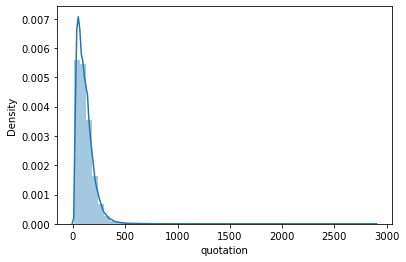

In [17]:
sns.distplot(context_df['quotation'].apply(len))

As plot shows, there are quotations that that too long while most of the quoations have a length less than 500.

In [40]:
context_df['quotation'].apply(len).quantile(0.98)

321.0

In [47]:
max=context_df['quotation'].apply(len).max()
context_df[context_df['quotation'].apply(len)==max].quotation.values

array(["Driven by strong underlying demand in North American non-residential roofing markets, Carlisle delivered record fourth quarter sales, operating income and diluted EPS. We accomplished these results despite the continued negative impact in the global economy driven by US/China trade negotiations, Brexit uncertainty, global industrial production declines and significant commercial aerospace production delays at a key customer. We continue to gain traction on the key pillars of Vision 2025, under which we target: $8 billion in revenues, 20% operating margin, and 15% ROIC, all driving to $15 of earnings per share. As we embark on year three of Vision 2025, we will build on the achievements of our first two years and continue to drive towards our objectives of: achieving 5% organic growth with leverage, utilizing the Carlisle Operating System (COS) to deliver efficiencies and annual cost savings of 1-2% of revenues, deploying $3 billion to build scale with synergistic acquisitions, 

As shown, the longest quotation seems normal. And it is reasonable that the very long quotation exists. So, we won't set any bounderarys on quotations.

Next, we start merging data with Wikidata dataset to filter speakers by nationality.

In [18]:
context_df.id

0           [Q265277]
1          [Q4169153]
2                 NaN
3                 NaN
4           [Q311440]
             ...     
680805    [Q16734363]
680806            NaN
680807            NaN
680808            NaN
680809        [Q6279]
Name: id, Length: 680810, dtype: object

In [19]:
sum(context_df[context_df.id.isna()].localTopSpeaker!='None')

6912

However as we see above there are many quotations that do not have a QID. This means that either the `localTopSpeaker` is `None` or the speaker does not show up in the wikidata file since we see 6912 non-`None` entries. So we drop the `NaN` values in the `id` column and convert it to list in the next cell.

In [20]:
context_df.id.dropna().apply(lambda x: x.lstrip("[").rstrip("]").split(","))

0           [Q265277]
1          [Q4169153]
4           [Q311440]
6           [Q311440]
8           [Q520173]
             ...     
680802     [Q5344760]
680803      [Q374346]
680804    [Q16734363]
680805    [Q16734363]
680809        [Q6279]
Name: id, Length: 493343, dtype: object

In [21]:
context_df.id.dropna().apply(lambda x: x.lstrip("[").rstrip("]").split(",")).apply(len).value_counts()

1      367383
2       38218
3       16035
5       13841
4       12106
        ...  
89          2
110         2
76          1
378         1
117         1
Name: id, Length: 114, dtype: int64

As we can see above, there are many speakers with multiple QIDs, which may be the case if they have very commom names. 

## Merging the speaker attributes

In [22]:
speaker_df = pd.read_parquet('C:/Users/jozef/Desktop/quotebank/speaker_attributes.parquet')
speaker_df

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9055976,[Barker Howard],None,[Q30],[Q6581097],1397399351,None,None,[Q82955],None,None,Q106406560,Barker B. Howard,None,item,None
9055977,[Charles Macomber],None,[Q30],[Q6581097],1397399471,None,None,[Q82955],None,None,Q106406571,Charles H. Macomber,None,item,None
9055978,None,[+1848-04-01T00:00:00Z],None,[Q6581072],1397399751,None,None,None,None,None,Q106406588,Dina David,None,item,None
9055979,None,[+1899-03-18T00:00:00Z],None,[Q6581072],1397399799,None,None,None,None,None,Q106406593,Irma Dexinger,None,item,None


Above we load the parquet file containing the speaker information. We merge this dataframe into the quotation dataframe on the QID's of the speaker.

In [23]:
context_df = context_df[~context_df['id'].isna()]

In [24]:
context_df = context_df[context_df.id.apply(lambda x: x.lstrip("[").rstrip("]").split(",")).apply(len) == 1]

In [25]:
context_df['id'] = context_df['id'].apply(lambda x: x[1:-1])

Above we removed wrong ids so we can merge the two dataframes

In [26]:
merged_df = pd.merge(context_df, speaker_df, on='id', how = 'left')
merged_df['nationality']

0           None
1          [Q30]
2          [Q45]
3          [Q45]
4         [Q928]
           ...  
367378    [Q258]
367379     [Q30]
367380     [Q16]
367381     [Q16]
367382     [Q30]
Name: nationality, Length: 367383, dtype: object

In [27]:
merged_df.columns

Index(['quotationOffset', 'quoteID', 'numOccurrences', 'quotation',
       'leftContext', 'rightContext', 'globalTopSpeaker', 'globalProbas',
       'localTopSpeaker', 'localProbas', 'title', 'date', 'articleID', 'id',
       'aliases', 'date_of_birth', 'nationality', 'gender', 'lastrevid',
       'ethnic_group', 'US_congress_bio_ID', 'occupation', 'party',
       'academic_degree', 'label', 'candidacy', 'type', 'religion'],
      dtype='object')

In [28]:
merged_df['nationality'].dropna().apply(len).max()

5

As we see above, we obtain much more possible information about the speaker of the quotation. Next we want to filter all the speakers that are not from a western country. For this filtering we have created our own dataframe which we use to define the QIDS of western countries. We also need to drop any rows who have an unspecified nationality. For the persons with multiple nationalities we check if any of them are in a western country

In [29]:
merged_df = merged_df[~merged_df['nationality'].isna()]

In [30]:
western_countries = pd.read_csv('western_countries_list.csv')

In [31]:
western_countries

,Country,QID
0,Andorra,Q228
1,Antigua and Barbuda,Q781
2,Argentina,Q414
3,Australia,Q408
4,Austria,Q40
5,The Bahamas,Q778
6,Barbados,Q244
7,Belgium,Q31
8,Belize,Q242
9,Bolivia,Q750


For the list of western countries, we used the [political definition](https://sashamaps.net/docs/maps/list-of-western-countries/) . We then obtained the QIDS from wikidata manually. 

In [32]:
western_df = merged_df[merged_df['nationality'].apply(lambda x: any(y in western_countries['QID'].to_list() for y in x))]

In [33]:
pd.merge(merged_df['nationality'].explode(), western_countries, left_on='nationality', right_on='QID', how = 'left')['Country'].value_counts()

United States of America     124844
United Kingdom                28884
Australia                     14549
Canada                        12456
France                         6904
Germany                        5030
Italy                          3889
Portugal                       2618
New Zealand                    2322
Spain                          1906
Ireland                        1492
Belgium                        1316
Sweden                         1312
Argentina                      1014
Brazil                          812
Denmark                         742
Greece                          675
Switzerland                     657
Austria                         645
Mexico                          517
Norway                          426
Venezuela                       393
Vatican City                    277
Jamaica                         152
Finland                         127
Chile                           126
Peru                             92
Croatia                     

As expected we see a very large amount of quotes from english speaking countries, as the news articles are in english.

## Summary of Data Cleaning

In this notebook we have observed the following points:
- We observed that some titles are too long, and as such we will remoove them in the data processing pipeline.
- We saw that we could not rely on the URL to extract the country of origin. 
- Next we saw that the title may not be representative of the topic of the quote so we decided to check the context and quote instead.
- Finally, we observed that most of the western quotes are from people with a english speaking nationality.

# Exploratory Data Analysis

After cleaning data, we can generally see how this dataset look like.

First, we can plot how data distributed in time. 

[Text(0.5, 0, 'date of first four months in 2020'),
 Text(0, 0.5, 'num of articles mentioning china')]

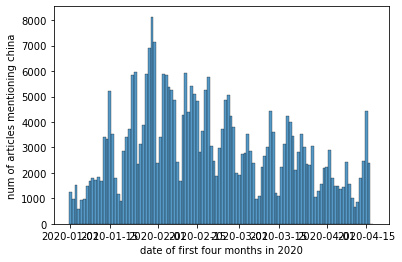

In [34]:
# check the number of articles discussing china over time for the first four months in 2020
sns.histplot(data=merged_df.date.dt.date).set(xlabel="date of first four months in 2020", ylabel="num of articles mentioning china")

[Text(0.5, 0, 'date of first four months in 2020'),
 Text(0, 0.5, 'num of articles mentioning china')]

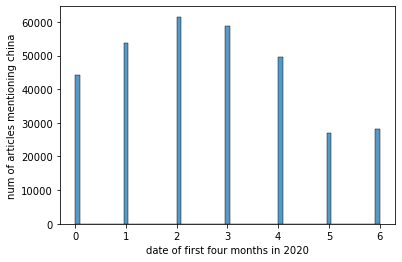

In [35]:
# check the number of articles discussing china over time for the first four months in 2020
sns.histplot(data=merged_df.date.dt.weekday).set(xlabel="date of first four months in 2020", ylabel="num of articles mentioning china")

As plot shows, We can observe a peak around the end of January, when Covid-19 outbreak in China caught attention. Also we can see the weekend has less news compared with weekdays.

Moreover, we can group speakers by different gender or nationality to see the distrbution.

[Text(0, 0, 'female'), Text(1, 0, 'male')]

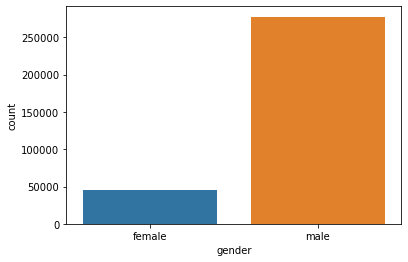

In [60]:
# compare male(Q6581097) and female(Q6581072) speakers
gender = merged_df.gender.apply(lambda x: x[0] if x is not None else None)
sns.countplot(x=gender[(gender == "Q6581097") | (gender == "Q6581072")]).set_xticklabels(["female", "male"])

In [73]:
merged_df.US_congress_bio_ID.count()/merged_df.quoteID.count()

0.08015001223262426

As shown above, most of speakers are male, and around 8% of speakers belong to US congress.